In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
metal = 'ZN'
encoder = 'COLLAPSE'
cutoff = 6.0
embed_dict_path = f"../data/{encoder}_{metal}_{cutoff}_train_embeddings_2.pkl"
processor_cache_dir = f"../data/{encoder}_{metal}_gridsearch_results_2/{encoder}-fitted_k2_processors"

In [3]:
from k2 import K2Processor

In [4]:
import utils
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import networkx as nx
import os

In [5]:
args = {"datatype":"protein",
        "k":20,
        "quantizer_type":"kmeans",
        "embeddings_path": embed_dict_path,
        "embeddings_type":"dict",
        "mapping_path": None,
        "sample_size": None,
        "sample_scheme": None,
        "dataset_path": None,
        "verbosity": "full",
        "so_dict_path": None}
proc = K2Processor(args)

Embeddings path provided, loading embeddings...


In [6]:
embed_dict = utils.deserialize(embed_dict_path)

In [7]:
len(embed_dict)

347270

In [10]:
processor_name = "k%d_cutoff%.2f.processor" % (args['k'], cutoff)

if processor_name in os.listdir(processor_cache_dir):
    print("Found fitted processor for k=%d, cutoff=%.2f" % (args['k'], cutoff))
    proc = utils.deserialize_model(os.path.join(proc_cache_dir, processor_name))
else:
    proc.fit_quantizer()

Chosen KMeans model for quantization...
sampled 2112 known salient objects!
total embeds: 347270
collapsing from dim 512 --> 2


In [ ]:
proc.visualize_quantizer(subsample=0.1)

# Sprite construction

In [11]:
G_dir = f"../data/{encoder}_{metal}_{cutoff}_train_graphs_2"

In [156]:
os.listdir(G_dir)[:10]

['5a89A.pkl',
 '3h09B.pkl',
 '4xezA.pkl',
 '6h0tA.pkl',
 '4hzdA.pkl',
 '3gdfB.pkl',
 '2c5wB.pkl',
 '1rkqB.pkl',
 '3klcB.pkl',
 '3ekgA.pkl']

Graph with 514 nodes and 1397 edges
colors (min, max): 0 19


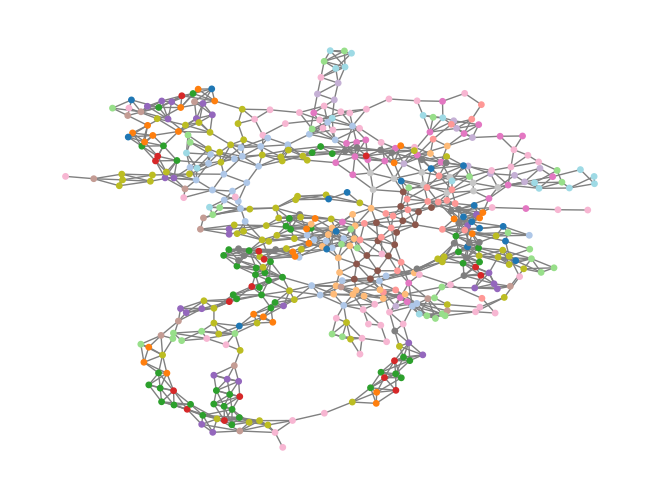

In [18]:
G_id = "6h0tA"
G_path = G_dir + "/" + G_id + ".pkl"
G = utils.deserialize(G_path)

sprite = utils.construct_sprite(G, proc)
print(sprite)
utils.visualize_sprite(sprite, modality="graph")

In [26]:
# nglview.show_file(f'/scratch/users/aderry/pdb/{G_id[1:3]}/{G_id}.ent.gz', ext='.ent.gz', compressed=True)
view = utils.visualize_protein_sprite(sprite)
view

NGLWidget()

In [17]:
import collections as col
col.Counter(nx.get_node_attributes(sprite, 'emb').values())

Counter({16: 76,
         13: 54,
         4: 53,
         1: 38,
         5: 35,
         8: 28,
         2: 27,
         12: 26,
         7: 26,
         3: 22,
         14: 21,
         0: 19,
         19: 18,
         6: 17,
         10: 16,
         11: 15,
         9: 13,
         15: 10})

In [12]:
from k2 import K2Model

In [128]:
# # hyperparameter sweep
# Ks = [10,15,20,25,30]
# rs = [0,1,2,4,8]
# alphas = [0.01, 0.025, 0.05, 1e10]
# taus = [0,1,2]

In [44]:
# label_dict = utils.deserialize("/home/data/tinycam/train/" + modelstr + "-label_dict.pkl")
hparams = {"alpha": 0.01, "tau": 0, "lambda": 0.5}
args = {"modality":"graph",
        "processor":proc,
        "r":4,
        "variant": "inferential",
        "hparams": hparams,
        "train_graph_path": G_dir}

In [45]:
k2m = K2Model(args)

In [46]:
k2m.create_train_array()

In [47]:
k2m.fit_kernel(alpha=0.01, tau=0)

updating alpha to 0.01
updating tau to 0
Differential Expression with alpha,tau: 0.01,0


<BarContainer object of 230 artists>

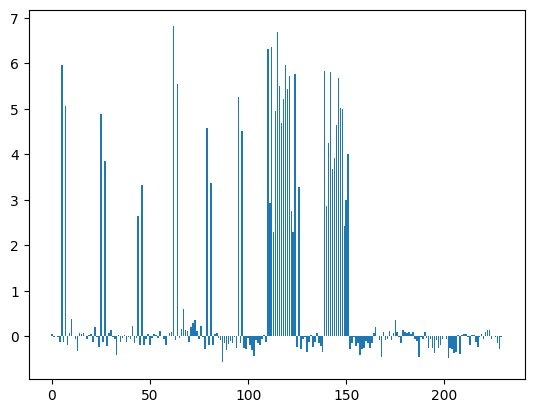

In [48]:
plt.bar(x=range(len(k2m.B)), height=list(k2m.B))

In [37]:
graph_path = f'../data/{encoder}_{metal}_{cutoff}_train_graphs_2'

print(os.listdir(graph_path)[:10])

G = utils.deserialize(os.path.join(graph_path, '2c5wB.pkl')) # 2c5wB.pkl
print(G.graph['label'])
P = k2m.prospect(G)
print(P)

['5a89A.pkl', '6h0tA.pkl', '1q3xB.pkl', '2c5wB.pkl', '1pj5A.pkl', '5ej8G.pkl', '3klcB.pkl', '3gkeB.pkl', '1hn0A.pkl', '2nxfA.pkl']
1
Graph with 385 nodes and 1044 edges


colors (min, max): 0 19


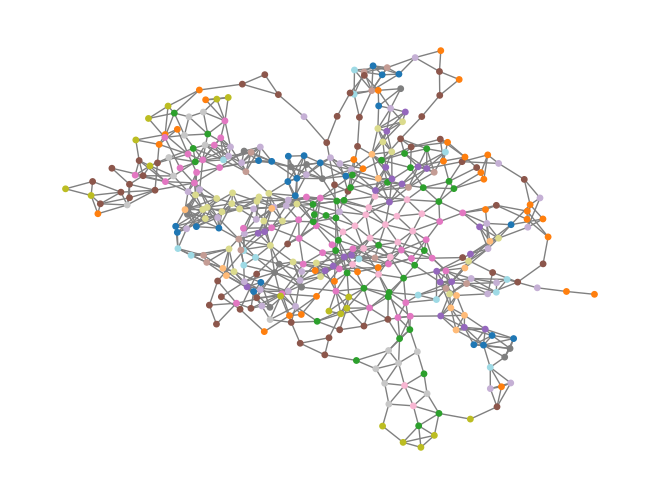

In [38]:
sprite = utils.construct_sprite(G, proc)
utils.visualize_sprite(sprite, modality="graph")

In [39]:
utils.visualize_protein_sprite(sprite)

NGLWidget()

Displaying motif graph with log10 scaling


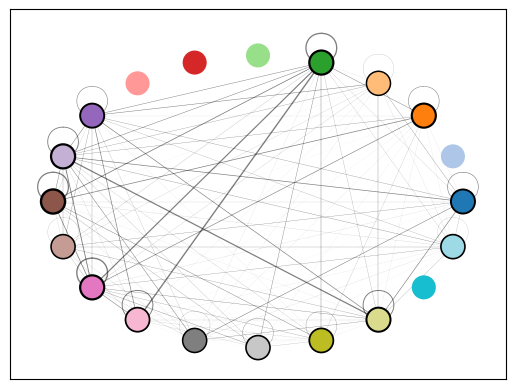

In [40]:
k2m.visualize_motif_graph(G)

In [41]:
G.graph["id"]

'2c5wB'

No G provided, showing model-wide kernel hash-graph
Displaying motif graph with log2 scaling


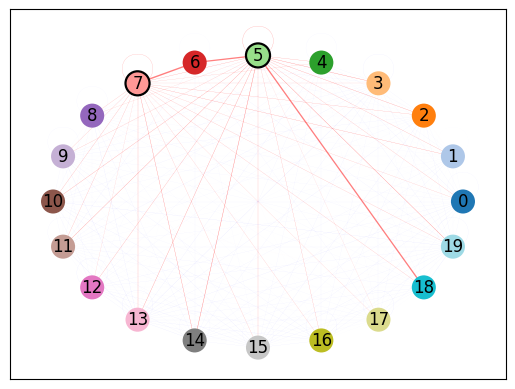

In [32]:
k2m.visualize_motif_graph(labels=True)

colors (min, max): -26 0


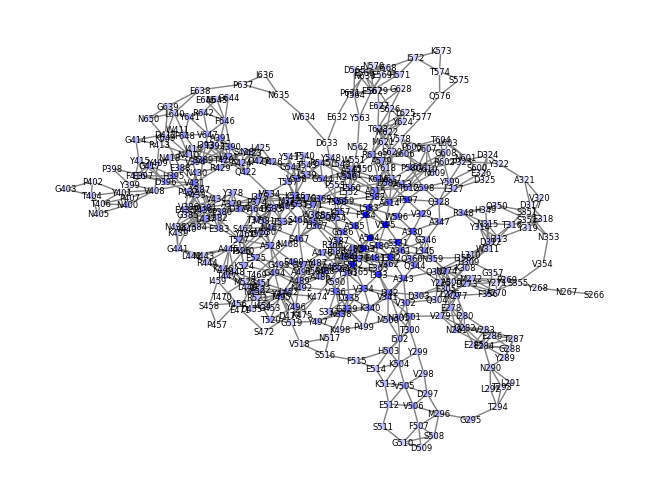

In [42]:
k2m.visualize_prospect_graph(P)

In [43]:
utils.visualize_protein_sprite(P, prospect_flag=True)

NGLWidget()

In [191]:
GT = utils.set_graph_emb(G, 'gt')

In [200]:
utils.visualize_protein_sprite(utils.set_graph_emb(G, 'gt'), prospect_flag=True)

NGLWidget()

In [193]:
thresholds = [np.round(el,1) for el in np.linspace(0,1,11)] # [0.1, 0.2, ..., 0.9, 1.0]
print(thresholds)

G = utils.expand_positive_nodes(G)

from evaluation import eval_suite
datum_thresh_msd_dict, datum_thresh_cm_dict, datum_cont, datum_pred, datum_linearized = eval_suite(G_id, P, utils.set_graph_emb(G, 'gt'), G.graph["label"], np.nan, thresholds)

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


In [197]:
utils.linearize_graph(utils.set_graph_emb(G, 'gt'))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [201]:
datum_thresh_cm_dict

{0.0: array([ 13, 371,   0,   1]),
 0.1: array([ 13, 365,   0,   7]),
 0.2: array([ 13, 359,   0,  13]),
 0.3: array([ 13, 356,   0,  16]),
 0.4: array([ 13, 353,   0,  19]),
 0.5: array([ 13, 331,   0,  41]),
 0.6: array([ 13, 288,   0,  84]),
 0.7: array([ 10, 207,   3, 165]),
 0.8: array([  2,  98,  11, 274]),
 0.9: array([  1,  53,  12, 319]),
 1.0: array([  0,   0,  13, 372])}

In [195]:
import metrics
for thresh, cm in datum_thresh_cm_dict.items():
    print(thresh, metrics.precision(cm))

0.0 0.033854166666666664
0.1 0.03439153439153439
0.2 0.03494623655913978
0.3 0.03523035230352303
0.4 0.03551912568306011
0.5 0.0377906976744186
0.6 0.04318936877076412
0.7 0.04608294930875576
0.8 0.02
0.9 0.018518518518518517
1.0 0


In [55]:
db = utils.deserialize('../data/metal_database_balanced.pkl')

In [59]:
G.graph['id']

'2bfdB'

In [70]:
pos_df = db['CA']['pos']
pos_df[pos_df['pdb_chain'] == G.graph['id']]['interactions'].tolist()

[['PO4_1358',
  'GLU_53',
  'ASN_224',
  'ASP_269',
  'HOH_2009',
  'ASN_168',
  'ASN_270'],
 ['PO4_1358',
  'GLU_53',
  'ASN_224',
  'ASP_269',
  'HOH_2009',
  'ASN_168',
  'ASN_270'],
 ['PO4_1358',
  'GLU_53',
  'ASN_224',
  'ASP_269',
  'HOH_2009',
  'ASN_168',
  'ASN_270'],
 ['HOH_2011', 'ASP_169', 'HOH_2053', 'HOH_2010', 'ILE_117', 'ASP_54'],
 ['HOH_2011', 'ASP_169', 'HOH_2053', 'HOH_2010', 'ILE_117', 'ASP_54'],
 ['HOH_2011', 'ASP_169', 'HOH_2053', 'HOH_2010', 'ILE_117', 'ASP_54']]

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [158]:
# # hyperparameter sweep
# ks = [10,15,20,25,30]
# rs = [0,1,2,4,8]
# alphas = [0.01, 0.025, 0.05, 1e10]
# taus = [0,1,2]

encoder = 'COLLAPSE'
metal = 'ZN'

if encoder == "AA":
    ks = [21]
else:
    ks = [15, 20, 25, 30]
rs = [0,1,2,4]
alphas = [0.001, 0.01, 0.1, 0.5, 1e10]
taus = [0, 1, 2]
lambdas = [0.5] # keep as elastic
cutoffs = [4.0, 6.0, 8.0] # edge cutoff for protein graph

save_dir = f"../data/{encoder}_{metal}_gridsearch_results"


In [159]:
metric_str = "precision"
results_cache_dir = f"../data/{encoder}_{metal}_gridsearch_results/{encoder}-eval_results"
model_cache_dir = f"../data/{encoder}_{metal}_gridsearch_results/{encoder}-fitted_k2_models"
linearized_cache_dir = f"../data/{encoder}_{metal}_gridsearch_results/{encoder}-linearized_data"

In [160]:
from model_selection import top_model_confusion
res_precision = top_model_confusion(metric_str,results_cache_dir, model_cache_dir, eval_class=1, return_all=True)

In [203]:
from model_selection import top_model_continuous_avg
res_auc = top_model_continuous_avg('auprc', results_cache_dir, model_cache_dir, return_all=True)

TypeError: top_model_continuous_avg() got an unexpected keyword argument 'return_all'

In [162]:
res = pd.merge(res_precision, res_auc, on=['k', 'r', 'cutoff', 'alpha', 'tau', 'lambda'], how='inner', suffixes=('_precision', '_auprc'))

In [163]:
res_inf = res.dropna(subset=['alpha', 'tau'])

In [164]:
res_inf['alpha'] = res_inf['alpha'].astype('str')

In [165]:
res_inf.sort_values(['score_precision', 'score_auprc'], ascending=False).iloc[:20]

,k,r,cutoff,alpha,tau,lambda,threshold,score_precision,stability,score_auprc
167,15,0,4.0,0.001,0.0,NaN,0.9,0.304167,0.304167,0.631201
308,15,0,6.0,0.001,0.0,NaN,0.9,0.304167,0.304167,0.631201
10,15,0,6.0,0.5,0.0,NaN,0.9,0.304167,0.304167,0.630075
20,15,0,6.0,10000000000.0,0.0,NaN,0.9,0.304167,0.304167,0.630075
60,15,0,6.0,0.1,0.0,NaN,0.9,0.304167,0.304167,0.630075
90,15,0,4.0,10000000000.0,0.0,NaN,0.9,0.304167,0.304167,0.630075
139,15,0,4.0,0.5,0.0,NaN,0.9,0.304167,0.304167,0.630075
238,15,0,4.0,0.1,0.0,NaN,0.9,0.304167,0.304167,0.630075
106,15,0,4.0,0.01,0.0,NaN,0.9,0.304167,0.304167,0.630046
155,15,0,6.0,0.01,0.0,NaN,0.9,0.304167,0.304167,0.630046


/oak/stanford/groups/rbaltman/aderry/miniconda3/envs/k2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/oak/stanford/groups/rbaltman/aderry/miniconda3/envs/k2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/oak/stanford/groups/rbaltman/aderry/miniconda3/envs/k2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/oak/stanford/groups/rbaltman/aderry/miniconda3/envs/k2/lib/python3.10/site-packages/seaborn/_oldcore.py:1

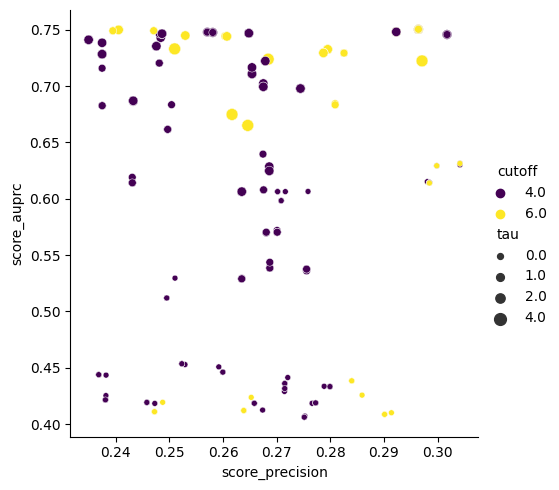

In [166]:
sns.relplot(data=res_inf, x='score_precision', y='score_auprc', hue='cutoff', size='tau', markers='r', palette='viridis')

/oak/stanford/groups/rbaltman/aderry/miniconda3/envs/k2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/oak/stanford/groups/rbaltman/aderry/miniconda3/envs/k2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/oak/stanford/groups/rbaltman/aderry/miniconda3/envs/k2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/oak/stanford/groups/rbaltman/aderry/miniconda3/envs/k2/lib/python3.10/site-packages/seaborn/_oldcore.py:1

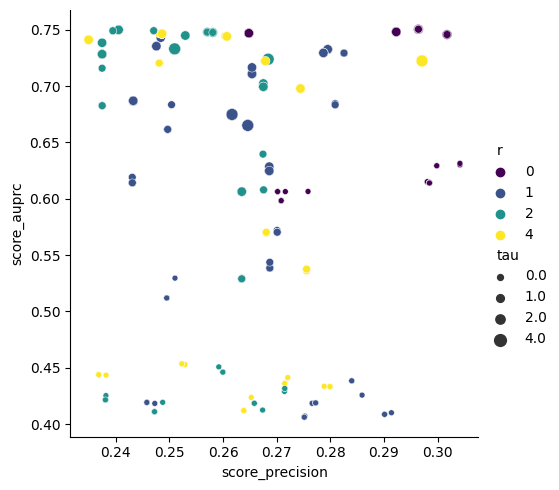

In [167]:
sns.relplot(data=res_inf, x='score_precision', y='score_auprc', hue='r', size='tau', markers='r', palette='viridis')

/oak/stanford/groups/rbaltman/aderry/miniconda3/envs/k2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/oak/stanford/groups/rbaltman/aderry/miniconda3/envs/k2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/oak/stanford/groups/rbaltman/aderry/miniconda3/envs/k2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/oak/stanford/groups/rbaltman/aderry/miniconda3/envs/k2/lib/python3.10/site-packages/seaborn/_oldcore.py:1

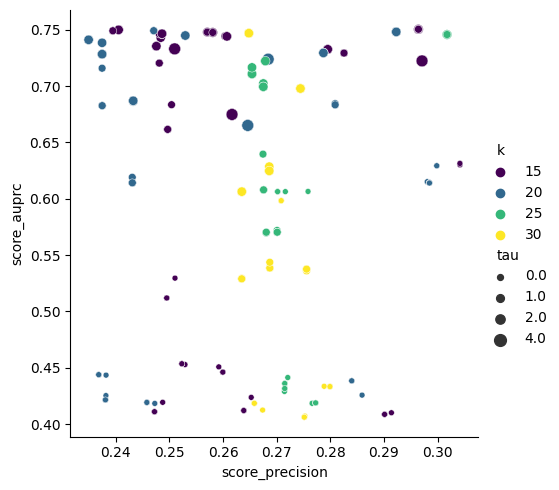

In [168]:
sns.relplot(data=res_inf, x='score_precision', y='score_auprc', hue='k', size='tau', markers='r', palette='viridis')

# Inspect results

In [4]:
import utils 
results_dict = utils.deserialize("../data/COLLAPSE_gridsearch_results/COLLAPSE-results_dict.obj")

In [5]:
results_dict

{'k10_r0_cutoff4.00_alphanan_taunan_lam0.50.model': '../data/COLLAPSE_gridsearch_results/COLLAPSE-eval_results/k10_r0_cutoff4.00_alphanan_taunan_lam0.50.model',
 'k10_r0_cutoff4.00_alpha0.010_tau0.00_lamnan.model': '../data/COLLAPSE_gridsearch_results/COLLAPSE-eval_results/k10_r0_cutoff4.00_alpha0.010_tau0.00_lamnan.model',
 'k10_r1_cutoff4.00_alphanan_taunan_lam0.50.model': '../data/COLLAPSE_gridsearch_results/COLLAPSE-eval_results/k10_r1_cutoff4.00_alphanan_taunan_lam0.50.model',
 'k10_r1_cutoff4.00_alpha0.010_tau0.00_lamnan.model': '../data/COLLAPSE_gridsearch_results/COLLAPSE-eval_results/k10_r1_cutoff4.00_alpha0.010_tau0.00_lamnan.model',
 'k10_r2_cutoff4.00_alphanan_taunan_lam0.50.model': '../data/COLLAPSE_gridsearch_results/COLLAPSE-eval_results/k10_r2_cutoff4.00_alphanan_taunan_lam0.50.model',
 'k10_r2_cutoff4.00_alpha0.010_tau0.00_lamnan.model': '../data/COLLAPSE_gridsearch_results/COLLAPSE-eval_results/k10_r2_cutoff4.00_alpha0.010_tau0.00_lamnan.model',
 'k15_r0_cutoff4.00_al

In [6]:
model_results = utils.deserialize(results_dict['k10_r0_cutoff4.00_alphanan_taunan_lam0.50.model'])

In [7]:
model_results

{'3h09B.pkl': {'thresh_msd': {0.0: 0.11211072664359861,
   0.1: 0.06725478207703729,
   0.2: 0.06725478207703729,
   0.3: 0.03408898185312906,
   0.4: 0.03408898185312906,
   0.5: 0.022908163265306123,
   0.6: 0.021363811728395063,
   0.7: 0.021363811728395063,
   0.8: 0.021664542691892955,
   0.9: 0.024197530864197528,
   1.0: 0,
   ('>', -0.04099866060757666): 964.0,
   ('<', -0.04099866060757666): 0},
  'thresh_cm': {0.0: array([  0, 810,   0, 154]),
   0.1: array([  0, 770,   0, 194]),
   0.2: array([  0, 770,   0, 194]),
   0.3: array([  0, 603,   0, 361]),
   0.4: array([  0, 603,   0, 361]),
   0.5: array([  0, 449,   0, 515]),
   0.6: array([  0, 443,   0, 521]),
   0.7: array([  0, 443,   0, 521]),
   0.8: array([  0, 221,   0, 743]),
   0.9: array([  0, 196,   0, 768]),
   1.0: array([  0,   0,   0, 964]),
   ('>', -0.04099866060757666): array([  0, 964,   0,   0]),
   ('<', -0.04099866060757666): array([  0,   0,   0, 964])},
  'cont': {'auroc': nan, 'auprc': nan, 'ap': nan}